In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

%matplotlib inline

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_process_input
from tensorflow.keras.layers import AveragePooling2D, Dropout, Dense, Flatten
model_name = 'MobileNetV2'

In [3]:
image_size = 224 
batch_size = 32
init_lr = 0.0_001
num_epochs = 20

!mkdir './MobileNetV2'
save_MobileNet = './MobileNetV2/'

## Load Dataset

In [4]:
dir_name = '../input/face-mask-12k-images-dataset/Face Mask Dataset/' 

train_path = os.path.join(dir_name, 'Train')
train_mask_path = os.path.join(dir_name, 'WithMask')
train_no_mask_path = os.path.join(dir_name, 'WithOutMask')

test_path = os.path.join(dir_name, 'Test')
test_mask_path = os.path.join(dir_name, 'WithMask')
test_no_mask_path = os.path.join(dir_name, 'WithOutMask')

val_path = os.path.join(dir_name, 'Validation')
val_mask_path = os.path.join(dir_name, 'WithMask')
val_no_mask_path = os.path.join(dir_name, 'WithOutMask')

## Preprocessing Dataset

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                  zoom_range = 0.2,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  shear_range = 0.15, 
                                  fill_mode = 'nearest',
                                  horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   target_size = (image_size, image_size))

validation_generator = test_datagen.flow_from_directory(test_path,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 target_size = (image_size, image_size))

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


## Model

In [6]:
mobileNet_base = MobileNetV2(include_top=False, pooling=None, input_shape=(image_size, image_size, 3))

inner = mobileNet_base.output

inner = AveragePooling2D(pool_size=(7, 7))(inner)
inner = Flatten()(inner)
inner = Dense(units=256, activation='relu')(inner)
inner = Dropout(0.2)(inner)
inner = Dense(units=2, activation='softmax')(inner)

model = Model(inputs=mobileNet_base.input, outputs=inner)

9412608/9406464 [==============================] - 0s 0us/step


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=init_lr, decay=init_lr / num_epochs),
              metrics=[Recall(name='recall'), 
                       'accuracy', 
                       Precision(name='precision')])

In [9]:
model_save_callback = ModelCheckpoint(filepath='./model-epoch{epoch:03d}-recall-{val_recall:.3f}-acc-{val_accuracy:.3f}.h5',
                                     monitor='val_recall', mode='max', 
                                     verbose=1, save_best_only=False, save_weights_only=True)

early_stop_callback = EarlyStopping(monitor='val_recall',  min_delta=0, patience=15, verbose=1, mode='max')

In [10]:
history = model.fit(train_generator,
                    steps_per_epoch=10000 // batch_size,
                    validation_data=validation_generator,
                    validation_steps=992 // batch_size,
                    epochs=num_epochs,
                    callbacks=[model_save_callback, early_stop_callback],
                    verbose=1)

Epoch 1/20
312/312 [==============================] - 197s 603ms/step - loss: 0.1232 - recall: 0.9545 - accuracy: 0.9545 - precision: 0.9545 - val_loss: 1.8182 - val_recall: 0.7560 - val_accuracy: 0.7560 - val_precision: 0.7560

Epoch 00001: saving model to ./model-epoch001-recall-0.756-acc-0.756.h5
Epoch 2/20
312/312 [==============================] - 122s 390ms/step - loss: 0.0149 - recall: 0.9959 - accuracy: 0.9959 - precision: 0.9959 - val_loss: 0.2436 - val_recall: 0.9476 - val_accuracy: 0.9476 - val_precision: 0.9476

Epoch 00002: saving model to ./model-epoch002-recall-0.948-acc-0.948.h5
Epoch 3/20
312/312 [==============================] - 123s 394ms/step - loss: 0.0056 - recall: 0.9976 - accuracy: 0.9976 - precision: 0.9976 - val_loss: 0.1404 - val_recall: 0.9677 - val_accuracy: 0.9677 - val_precision: 0.9677

Epoch 00003: saving model to ./model-epoch003-recall-0.968-acc-0.968.h5
Epoch 4/20
312/312 [==============================] - 121s 387ms/step - loss: 0.0044 - recall: 0.

In [11]:
model.save('mobileNetV2_model.h5')

## Evaluate Model

In [12]:
import pandas as pd

train_stats = pd.DataFrame(history.history)

train_stats.sort_values(by=['val_recall'], inplace=False, ascending=False)

,loss,recall,accuracy,precision,val_loss,val_recall,val_accuracy,val_precision
19,0.000116,1.000000,1.000000,1.000000,3.932230e-07,1.000000,1.000000,1.000000
11,0.001495,0.999398,0.999398,0.999398,1.747326e-05,1.000000,1.000000,1.000000
18,0.003198,0.998997,0.998997,0.998997,1.376679e-05,1.000000,1.000000,1.000000
17,0.001405,0.999398,0.999398,0.999398,6.733786e-05,1.000000,1.000000,1.000000
13,0.000138,1.000000,1.000000,1.000000,3.335732e-05,1.000000,1.000000,1.000000
9,0.003371,0.999197,0.999197,0.999197,6.435367e-04,1.000000,1.000000,1.000000
12,0.000100,1.000000,1.000000,1.000000,1.427713e-04,1.000000,1.000000,1.000000
16,0.001923,0.999398,0.999398,0.999398,6.307679e-03,0.998992,0.998992,0.998992
15,0.005811,0.998595,0.998595,0.998595,2.980712e-03,0.998992,0.998992,0.998992
7,0.002561,0.999097,0.999097,0.999097,8.581669e-03,0.998992,0.998992,0.998992


<AxesSubplot:>

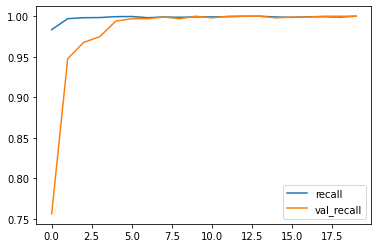

In [13]:
train_stats.plot(y=['recall', 'val_recall'], kind='line')

<AxesSubplot:>

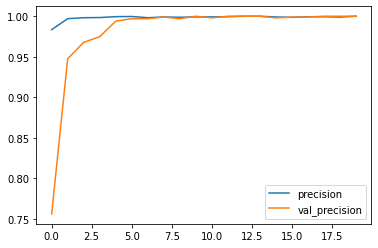

In [14]:
train_stats.plot(y=['precision', 'val_precision'], kind='line')

<AxesSubplot:>

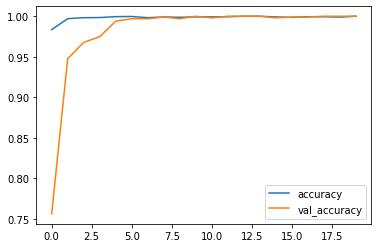

In [15]:
train_stats.plot(y=['accuracy', 'val_accuracy'], kind='line')

<AxesSubplot:>

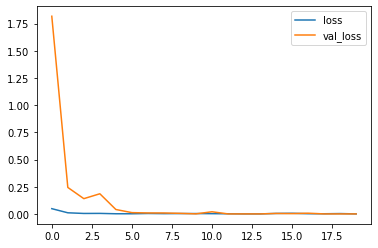

In [16]:
train_stats.plot(y=['loss', 'val_loss'], kind='line')

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)



    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')


target_names = []

for key in train_generator.class_indices:
    target_names.append(key)

Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

"""print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')"""

print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Classification Report
              precision    recall  f1-score   support

    WithMask       0.48      0.48      0.48       483
 WithoutMask       0.51      0.51      0.51       509

    accuracy                           0.50       992
   macro avg       0.50      0.50      0.50       992
weighted avg       0.50      0.50      0.50       992



In [18]:
img_path = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithMask/1002.png'
img = image.load_img(img_path, target_size = (image_size, image_size, 3))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

model.predict(img)

array([[1., 0.]], dtype=float32)

In [19]:
img_path = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/1016.png'
img = image.load_img(img_path, target_size = (image_size, image_size, 3))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

model.predict(img)

array([[1., 0.]], dtype=float32)